# Mercari Price Suggestion Challenge

**What is Mercari?**

[Mercari](https://www.mercari.com/) is Japan’s biggest community-powered marketplace. It is like Ebay or Amazon in the US. 

They wanted to offer pricing suggestions to sellers, so they created a [ Kaggle competition](https://www.kaggle.com/c/mercari-price-suggestion-challenge), to come up with a model.

Using the data that Mercari published, I created a price recommender for my web application, MapMarket.


**Problem Statement**

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost 335 dollars and the other cost 9.99 dollars. Can you guess which one’s which?

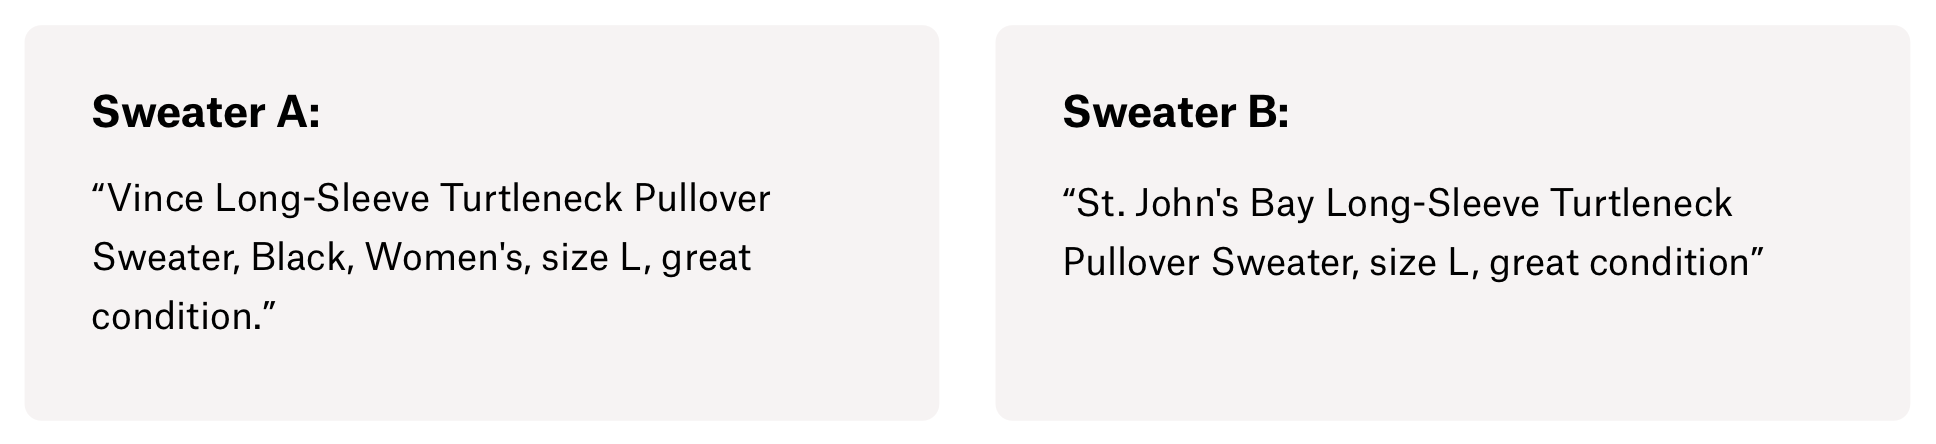

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

# MapMarket Price Recomendator

Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Data prepocesing
import numpy as np
import pandas as pd

# Data cleaning
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

# Model
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib

# Data Prepocesing


Import the train DataFrame

In [2]:
df = pd.read_csv('train.tsv', sep='\t')

Display the first few rows of the DataFrame

In [3]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


Remove `train_id` and `shipping` columns

In [4]:
df = df.drop(['train_id', 'shipping'], axis=1)

Remove all the information before the last forward slash in each string of the `category_name` column

In [5]:
df['category_name'] = df['category_name'].str.rsplit('/', n=1).str[-1].str.strip()

Display the new DataFrame

In [6]:
df

,name,item_condition_id,category_name,brand_name,price,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,T-shirts,NaN,10.0,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Components & Parts,Razer,52.0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Blouse,Target,10.0,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home Décor Accents,NaN,35.0,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Necklaces,NaN,44.0,Complete with certificate of authenticity
...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Mid-Calf,Free People,20.0,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Dresses,Disney,14.0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Fitness accessories,NaN,12.0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home Décor Accents,NaN,45.0,There is 2 of each one that you see! So 2 red ...


# Data Cleaning

## Missing values

In [7]:
df.isnull().sum(axis=0)

name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
item_description          6
dtype: int64

In [8]:
total_rows = df.shape[0]
null_values = df.isnull().sum(axis=0)
print("Null category", round(null_values['category_name']/total_rows*100,2),'%')
print("Null brand", round(null_values['brand_name']/total_rows*100,2),'%')
print("Null description", round(null_values['item_description']/total_rows*100,4),'%')

Null category 0.43 %
Null brand 42.68 %
Null description 0.0004 %


Remove sales that do not have a category

In [9]:
df.dropna(subset=['category_name'], inplace=True)

Remove sales that do not have a description

In [10]:
df.dropna(subset=['item_description'], inplace=True)

Remove sales that have "No description yet" as the sale description

In [11]:
df = df[df['item_description'] != 'No description yet']

## Price Analysis

Plot the distribution of the prices

<Axes: xlabel='price', ylabel='Density'>

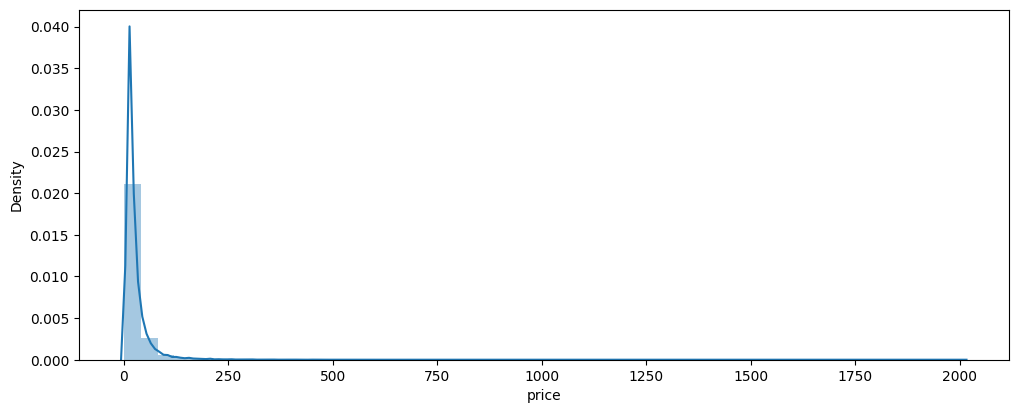

In [12]:
plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(df['price'])

Remove the sales with price less than $5

In [13]:
df = df[df['price']>=5]

99% of the sales have prices with less that $170

In [14]:
print("Number of sales with price more than $170 = ",len(df[df['price'] > 170]))

Number of sales with price more than $170 =  14292


Remove the sales with price more than $170

In [15]:
df = df[df['price'] <= 170]

<Axes: xlabel='price', ylabel='Density'>

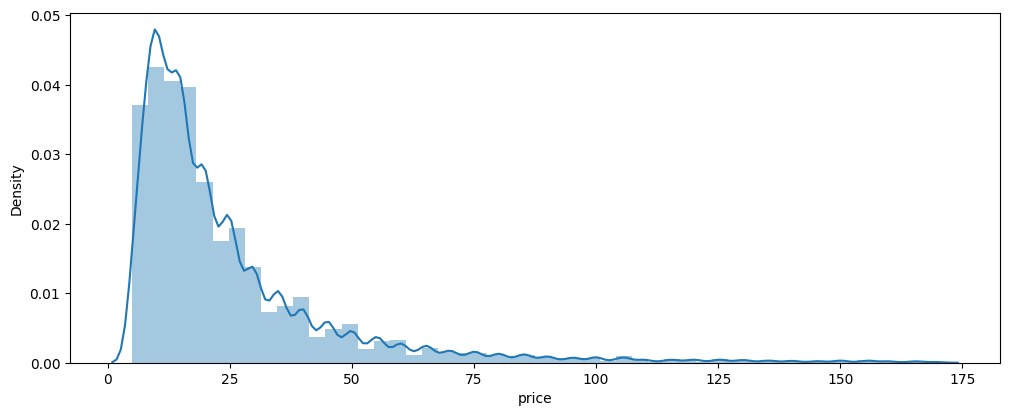

In [16]:
plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(df['price'])

Applying log transform on the price

In [17]:
df['log_price']= np.log(df['price'].values)

<Axes: xlabel='log_price', ylabel='Density'>

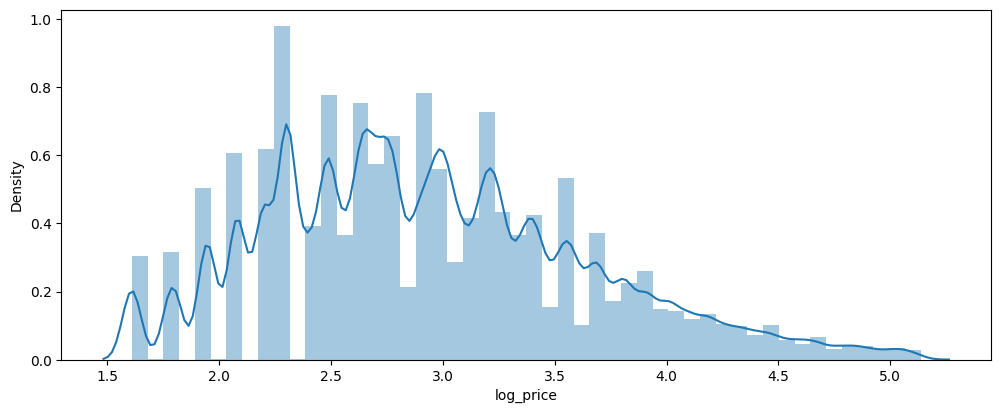

In [18]:
plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(df['log_price'])

## Reduce the number of categories

There are 868 different categories

In [19]:
df['category_name'].nunique()

868

Remove categories with a value count of 10 or less

In [20]:
df.loc[df['category_name'].isin(df['category_name'].value_counts()[df['category_name'].value_counts() <= 10].index.tolist() ), 'category_name'] = np.NAN 
df.dropna(subset=['category_name'], inplace=True)

There are less categories now

In [21]:
df['category_name'].nunique()

675

In [22]:
df['category_name'].value_counts()

category_name
Pants, Tights, Leggings             57149
Face                                47311
Other                               45449
T-Shirts                            41815
Shoes                               30021
                                    ...  
Home Brewing & Wine Making             11
Lithographs, Etchings & Woodcuts       11
Dehumidifiers                          11
Biography                              11
Clock                                  11
Name: count, Length: 675, dtype: int64

## Reduce the number of brands

There are 4787 different brands

In [23]:
df['brand_name'].nunique()

4677

Replace brands with NaN and with a value count of 10 or less with 'No Brand'

In [24]:
df.loc[df['brand_name'].isin(df['brand_name'].value_counts()[df['brand_name'].value_counts() <= 10].index.tolist() ), 'brand_name'] = np.NAN
df['brand_name'].fillna(value='No Brand', inplace=True)

There are less categories now

In [25]:
df['brand_name'].nunique()

1633

In [26]:
df['brand_name'].value_counts()

brand_name
No Brand             575174
PINK                  50964
Nike                  50746
Victoria's Secret     45933
LuLaRoe               27952
                      ...  
abercrombie kids         11
Supra                    11
Dave & Johnny            11
Hype                     11
Caterpillar              11
Name: count, Length: 1633, dtype: int64

**Result:**

In [27]:
df

,name,item_condition_id,category_name,brand_name,price,item_description,log_price
1,Razer BlackWidow Chroma Keyboard,3,Components & Parts,Razer,52.0,This keyboard is in great condition and works ...,3.951244
2,AVA-VIV Blouse,1,Blouse,Target,10.0,Adorable top with a hint of lace and a key hol...,2.302585
3,Leather Horse Statues,1,Home Décor Accents,No Brand,35.0,New with tags. Leather horses. Retail for [rm]...,3.555348
4,24K GOLD plated rose,1,Necklaces,No Brand,44.0,Complete with certificate of authenticity,3.784190
5,Bundled items requested for Ruie,3,Other,No Brand,59.0,"Banana republic bottoms, Candies skirt with ma...",4.077537
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Mid-Calf,Free People,20.0,"Lace, says size small but fits medium perfectl...",2.995732
1482531,Little mermaid handmade dress,2,Dresses,Disney,14.0,Little mermaid handmade dress never worn size 2t,2.639057
1482532,21 day fix containers and eating plan,2,Fitness accessories,No Brand,12.0,"Used once or twice, still in great shape.",2.484907
1482533,World markets lanterns,3,Home Décor Accents,No Brand,45.0,There is 2 of each one that you see! So 2 red ...,3.806662


Save categories

In [28]:
categories = pd.DataFrame(df['category_name'].unique(), columns=['name'])
categories.to_excel('categories.xlsx', index=False)
categories

,name
0,Components & Parts
1,Blouse
2,Home Décor Accents
3,Necklaces
4,Other
...,...
670,Basket
671,"Lithographs, Etchings & Woodcuts"
672,Blanket
673,Mixed Media


Save brands

In [29]:
brands = pd.DataFrame(df['brand_name'].unique(), columns=['name'])
brands.to_excel('brands.xlsx', index=False)
brands

,name
0,Razer
1,Target
2,No Brand
3,Acacia Swimwear
4,Soffe
...,...
1628,Black Rivet
1629,William Rast
1630,Disney Baby
1631,Ecote


# Feature Engineering:

## Text Pre-Processing

In [30]:
def preprocess_text(text):

  # Lowercase the text
  text = text.lower()

  # Remove punctuation and numbers
  text = re.sub(r'[^\w\s]', '', text)

  # Remove stop words
  stop_words = stopwords.words('english')
  text = [word for word in text.split() if word not in stop_words]

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  text = [lemmatizer.lemmatize(word) for word in text]

  return text

In [31]:
df['text'] = df['name'] + ' ' + df['item_description']

run venv: python -m nltk.downloader all

In [32]:
preprocessed_text = df['text'].apply(preprocess_text)

**Result:**

In [33]:
df['text']

1          Razer BlackWidow Chroma Keyboard This keyboard...
2          AVA-VIV Blouse Adorable top with a hint of lac...
3          Leather Horse Statues New with tags. Leather h...
4          24K GOLD plated rose Complete with certificate...
5          Bundled items requested for Ruie Banana republ...
                                 ...                        
1482530    Free People Inspired Dress Lace, says size sma...
1482531    Little mermaid handmade dress Little mermaid h...
1482532    21 day fix containers and eating plan Used onc...
1482533    World markets lanterns There is 2 of each one ...
1482534    Brand new lux de ville wallet New with tag, re...
Name: text, Length: 1346995, dtype: object

In [34]:
preprocessed_text

1          [razer, blackwidow, chroma, keyboard, keyboard...
2          [avaviv, blouse, adorable, top, hint, lace, ke...
3          [leather, horse, statue, new, tag, leather, ho...
4          [24k, gold, plated, rose, complete, certificat...
5          [bundled, item, requested, ruie, banana, repub...
                                 ...                        
1482530    [free, people, inspired, dress, lace, say, siz...
1482531    [little, mermaid, handmade, dress, little, mer...
1482532    [21, day, fix, container, eating, plan, used, ...
1482533    [world, market, lantern, 2, one, see, 2, red, ...
1482534    [brand, new, lux, de, ville, wallet, new, tag,...
Name: text, Length: 1346995, dtype: object

In [35]:
text_list = preprocessed_text.tolist()
text_list

[['razer',
  'blackwidow',
  'chroma',
  'keyboard',
  'keyboard',
  'great',
  'condition',
  'work',
  'like',
  'came',
  'box',
  'port',
  'tested',
  'work',
  'perfectly',
  'light',
  'customizable',
  'via',
  'razer',
  'synapse',
  'app',
  'pc'],
 ['avaviv',
  'blouse',
  'adorable',
  'top',
  'hint',
  'lace',
  'key',
  'hole',
  'back',
  'pale',
  'pink',
  '1x',
  'also',
  '3x',
  'available',
  'white'],
 ['leather',
  'horse',
  'statue',
  'new',
  'tag',
  'leather',
  'horse',
  'retail',
  'rm',
  'stand',
  'foot',
  'high',
  'sold',
  'pair',
  'question',
  'please',
  'ask',
  'free',
  'shipping',
  'got',
  'storage'],
 ['24k', 'gold', 'plated', 'rose', 'complete', 'certificate', 'authenticity'],
 ['bundled',
  'item',
  'requested',
  'ruie',
  'banana',
  'republic',
  'bottom',
  'candy',
  'skirt',
  'matching',
  'blazeramy',
  'byers',
  'suit',
  'loft',
  'bottom',
  'cami',
  'top'],
 ['acacia',
  'pacific',
  'tide',
  'santorini',
  'top',
  '

In [36]:
flat_text_list = [' '.join(sublist) for sublist in text_list]
flat_text_list

['razer blackwidow chroma keyboard keyboard great condition work like came box port tested work perfectly light customizable via razer synapse app pc',
 'avaviv blouse adorable top hint lace key hole back pale pink 1x also 3x available white',
 'leather horse statue new tag leather horse retail rm stand foot high sold pair question please ask free shipping got storage',
 '24k gold plated rose complete certificate authenticity',
 'bundled item requested ruie banana republic bottom candy skirt matching blazeramy byers suit loft bottom cami top',
 'acacia pacific tide santorini top size small strap slightly shortened fit x besides perfect condition',
 'girl cheer tumbling bundle 7 get three pair sophie cheer short size small medium girl two sport braboy short spandex matching set small medium girl item total retail rm store take today le price one item store',
 'girl nike pro short girl size small plus green three short total',
 'porcelain clown doll checker pant vtg realized pant backwar

In [37]:
tv_text = TfidfVectorizer()
vectorized_text = tv_text.fit_transform(flat_text_list)
vectorized_text

<1346995x321779 sparse matrix of type '<class 'numpy.float64'>'
	with 24279174 stored elements in Compressed Sparse Row format>

## Category

In [38]:
he_category = OneHotEncoder()
encoded_category = he_category.fit_transform(df[['category_name']])
encoded_category

<1346995x675 sparse matrix of type '<class 'numpy.float64'>'
	with 1346995 stored elements in Compressed Sparse Row format>

## Condition

In [39]:
he_condition = OneHotEncoder()
encoded_condition = he_condition.fit_transform(df[['item_condition_id']])
encoded_condition

<1346995x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1346995 stored elements in Compressed Sparse Row format>

## Brand

In [40]:
he_brand = OneHotEncoder()
encoded_brand = he_brand.fit_transform(df[['brand_name']])
encoded_brand

<1346995x1633 sparse matrix of type '<class 'numpy.float64'>'
	with 1346995 stored elements in Compressed Sparse Row format>

## Combine Features

In [41]:
features = hstack([vectorized_text, encoded_category, encoded_condition, encoded_brand])
features

<1346995x324092 sparse matrix of type '<class 'numpy.float64'>'
	with 28320159 stored elements in Compressed Sparse Row format>

In [42]:
features

<1346995x324092 sparse matrix of type '<class 'numpy.float64'>'
	with 28320159 stored elements in Compressed Sparse Row format>

# Model

## Train-Test Split 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, df['log_price'], test_size=0.2, random_state=42)

## Train

Create a LightGBM dataset for training

In [44]:
train_data = lgb.Dataset(X_train, label=y_train)

Specify the LightGBM model parameters in a dictionary.

In [45]:
params = {
    'learning_rate': 0.75,
    'application': 'regression',
    'max_depth': 3,
    'num_leaves': 100,
    'verbosity': -1,
    'metric': 'RMSE',
}

Train the LightGBM model

In [46]:
gbm = lgb.train(params, train_set=train_data, num_boost_round=3200)

## Predict

Uses the trained LightGBM model to predict on the test set

In [47]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

## Evaluate using RMSLE

In [48]:
def rmsle(y_true, y_pred):
  return np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_true + 1))**2))

In [49]:
rmse = rmsle(y_test, y_pred)
print("Model RMSLE:", rmse)

Model RMSLE: 0.11936700643623502


## Model Evaluation

Compare real values with predictions

In [50]:
comparison_df = pd.DataFrame({'y_test (log)': y_test, 'y_pred (log)': y_pred, 'y_test': np.expm1(y_test), 'y_pred': np.expm1(y_pred)})
comparison_df.head(50)

,y_test (log),y_pred (log),y_test,y_pred
1293213,3.218876,3.219748,24.0,24.021821
1319534,2.708050,2.630309,14.0,12.878055
1287284,2.302585,2.438964,9.0,10.461166
227519,1.791759,2.698226,5.0,13.853355
1166945,2.484907,2.972087,11.0,18.532642
26477,2.890372,3.689261,17.0,39.015277
184379,2.772589,3.836997,15.0,45.385946
128220,2.708050,2.712043,14.0,14.060015
1318020,3.135494,2.842519,22.0,16.158927
1115504,4.174387,3.928490,64.0,49.830159


In [51]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.35667115831304375


## Save Model

Save using joblib

In [52]:
joblib.dump(tv_text, 'tv_text.joblib')
joblib.dump(he_category, 'he_category.joblib')
joblib.dump(he_condition, 'he_condition.joblib')
joblib.dump(he_brand, 'he_brand.joblib')

['he_brand.joblib']

Save the trained LightGBM model

In [53]:

gbm.save_model('lgb_model.txt')